In [1]:
#from sklearn.metrics.pairwise import pairwise_distances

from itertools import product
from PIL import Image, ImageOps

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
plt = matplotlib.pyplot

%matplotlib inline

sns.set_style('whitegrid')

matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

In [2]:
image_size = (32, 32)
images_per_class = 3000
flip_images = False # Will double the images_per_class

In [3]:
%%time

import random

# the directory immediately under which all the images
# reside.
file_prefix = 'data/'

# The PIL flag for grayscale.
GRAYSCALE_MODE = 'L'

# Will store tuples (id,image_data,is_dog) and then
# will be converted into the DataFrame `images`.
images_list = []

# load data/cat.{i}.jpg and data/dog.{i}.jpg
# for i in a random sampling without replacement of
# an integer population 0...9999 inclusive (all image indices).
for pet_type, index in product(['cat', 'dog'], random.sample(range(10000), images_per_class)):
    file_name = f'{pet_type}.{index}'
    
    # Load and convert to grayscale
    image = Image.open(f'{file_prefix}{file_name}.jpg').convert(mode=GRAYSCALE_MODE)
    
    # Aspect fit the image (shrink the image while maintaining
    # the aspect ratio such that the shorter dimension matches its target value
    # in image_size above. Then center it and crop off the excess to fit in
    # the dimensions of image_size).
    image = ImageOps.fit(image, image_size, method=Image.ANTIALIAS)
    
    # The PIL.ImageData object is essentially a matrix. Linearize it as a numpy array.
    data = (np.array(image.getdata())/255).astype('float32')
    
    # Add the boolean field `is_dog` as a simple representation of our cat/dog dichotomy.
    is_dog = (pet_type == 'dog')
    images_list.append((file_name,data,is_dog))
    
    # Flip the image left/right and add to the data set
    # This is an attempt to help avoiding the overtrainging of our model.
    if flip_images:
        image_f = image.transpose(Image.FLIP_LEFT_RIGHT)
        data_f = (np.array(image_f.getdata())/255).astype('float32')
        images_list.append((file_name+'.f',data_f,is_dog))
        
images = pd.DataFrame(data=images_list,columns=['id','image_data','is_dog'])

CPU times: user 42.7 s, sys: 937 ms, total: 43.6 s
Wall time: 45.9 s


In [4]:
images.head()

,id,image_data,is_dog
0,cat.8949,"[0.403922, 0.462745, 0.482353, 0.462745, 0.392...",False
1,cat.8280,"[0.156863, 0.266667, 0.419608, 0.537255, 0.619...",False
2,cat.5744,"[0.788235, 0.831373, 0.952941, 0.956863, 0.901...",False
3,cat.6879,"[0.270588, 0.262745, 0.247059, 0.298039, 0.298...",False
4,cat.5787,"[0.145098, 0.12549, 0.0941176, 0.129412, 0.207...",False


In [5]:
print('images stored as dtype',images.image_data[0].dtype)
print(images_per_class*2,'images,',image_size,'pixels each')
mem = images.memory_usage(deep=True).sum()
print('float64 size:',mem*2/1000000.,'MB')
print('float32 size:',mem/1000000.,'MB')

images stored as dtype float32
6000 images, (32, 32) pixels each
float64 size: 51.190868 MB
float32 size: 25.595434 MB


In [6]:
# [CITE] "04. Dimension Reduction and Images Notebook" by Eric Larson

def plot_gallery(imgs, titles, size, rows=3, cols=6):
    plt.figure(figsize = (1.7 * cols, 2.3 * rows))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        ax = plt.gca()
        [spine.set_color('black') for _,spine in ax.spines.items()]
        plt.imshow(imgs[i].reshape(size), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks([]); plt.yticks([])
    plt.show()

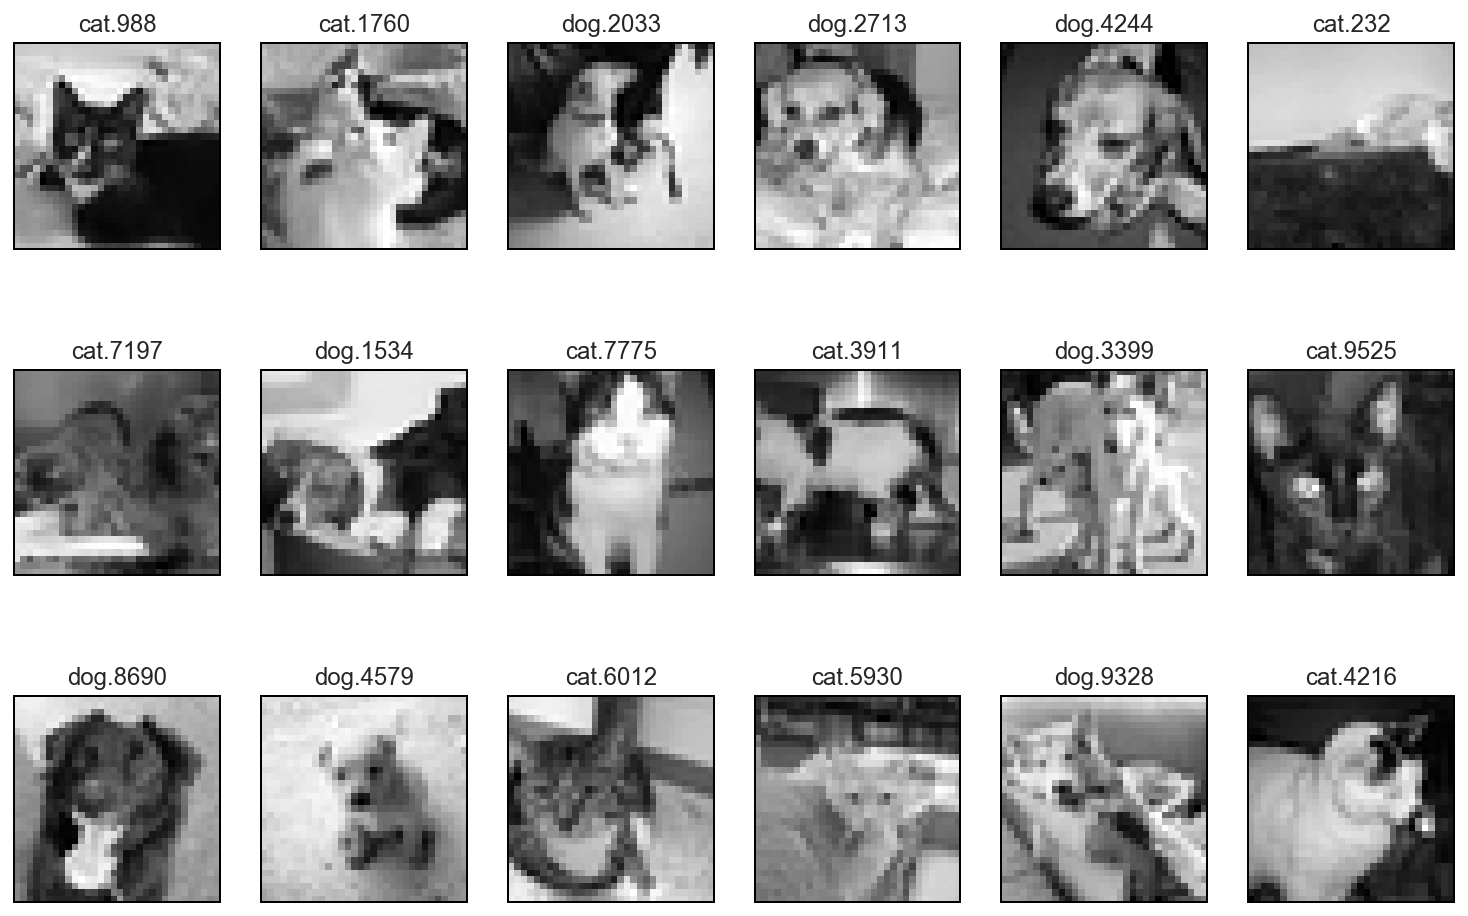

In [7]:
some_images = images.sample(n=18)
plot_gallery(some_images.image_data.iloc, some_images.id.iloc, image_size)

In [8]:
from sklearn.metrics import roc_auc_score
evaluation_function = roc_auc_score

from sklearn.model_selection import StratifiedKFold

n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, random_state=None, shuffle=False)

In [9]:
# we store the networks in this array
# so we can grab their epoch_log_ properties
# wherein we persist the per-epoch accuracy
# so we can make pretty charts.
def cross_validation_step(ModelClass, indices, parameters): 
    train_index, test_index = indices
    X_train = data.iloc[train_index]
    y_train = np.asarray(pd.get_dummies(target.iloc[train_index]))
    X_test = data.iloc[test_index]
    y_test = target.iloc[test_index]
    
    # training
    clf = ModelClass(**parameters)
    clf.fit(X_train, y_train)
    
    # testing
    y_hat_raw = clf.predict(X_test)
    y_hat = ModelClass.one_hot_output(y_hat_raw)
    score = evaluation_function(pd.get_dummies(y_test), y_hat)
    return score,clf

def cross_validation(ModelClass, cv, parameters):
    cv_indices = cv.split(data, target)
    scores = np.empty(n_splits)
    nets = [None]*n_splits
    
    if 'epochs' in parameters:
        total_epochs = n_splits*parameters['epochs']
        print(
            f'Performing {n_splits}-fold Stratified cross validation with {parameters["epochs"]} '
            f'epochs each ({total_epochs} epochs total)'
        )
        if total_epochs > 80:
            print('☕️ you may want to grab a coffee')
        
    # I promise I tried parallelizing this 
    # but Tensorflow didn't like it.
    #
    # (tried threading.Thread and multiprocess.Pool)
    for i,indices in enumerate(cv_indices):
        print(f'Split {i+1} of {n_splits} {"☕️"*(i+1)}')
        scores[i],nets[i] = cross_validation_step(ModelClass, indices, parameters)
        
    return scores,nets

def get_logs_from_nets(nets, parameter_name):
    return [[epoch[parameter_name] for epoch in net.epoch_log_] for net in nets]

# Current CNN

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, BatchNormalization, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import Callback

class ConvolutionalNeuralNet:
    def __init__(
        self,
        input_shape,
        n_filters, 
        convolution_kernel_sizes, 
        pool_size,
        dense_sizes,
        final_dense_size,
        convolution_dropout_rate=0.0,
        dense_dropout_rate=0.0,

        convolution_activation='relu',
        dense_activation='relu',
        final_activation='softmax',

        loss='mean_squared_error', 
        optimizer='rmsprop', 
        metrics=['binary_accuracy'],

        batch_size=32,
        epochs=50,
        shuffle=False,
        verbose=2
    ):
        self.input_shape = input_shape
        self.n_filters = n_filters
        self.convolution_kernel_sizes = convolution_kernel_sizes
        self.pool_size = pool_size
        self.dense_sizes = dense_sizes
        self.final_dense_size = final_dense_size
        self.convolution_dropout_rate = convolution_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.convolution_activation = convolution_activation
        self.dense_activation = dense_activation
        self.final_activation = final_activation
        
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffle = shuffle
        self.verbose = verbose
        
        self._make_model()
    
    def _make_convolution_layers(self):
        output_size_for_dimension = lambda dim: int(self.input_shape[dim]/(self.pool_size[dim]*(i+1)))
            
        if len(self.n_filters) != len(self.convolution_kernel_sizes):
            raise ValueError('Provide the same length lists for n_filters and convolution_kernel_sizes.')
            
        self._model.add(
            Reshape(
                (1, self.input_shape[0], self.input_shape[1]), 
                input_shape=(1, self.input_shape[0]*self.input_shape[1])
            )
        )
                       
        for i in range(len(self.n_filters)):
            if output_size_for_dimension(0) == 0 or output_size_for_dimension(1) == 0:
                print("Warning: Size zero layer defined with input_shape (1,0,0). Reduce layer count")
                
            # Add a single convolution layer
            self._model.add(
                Conv2D(
                    filters=self.n_filters[i],
                    kernel_size=self.convolution_kernel_sizes[i],
                    padding='same',
                    activation=self.convolution_activation
                )
            )
            # Add batch normalization to the convolution layer
            self._model.add(
                BatchNormalization(axis=1)
            )
            # Pool the layer
            self._model.add(
                MaxPooling2D(pool_size=self.pool_size, data_format='channels_first')
            )
        

        self._model.add(
            Dropout(self.convolution_dropout_rate)
        )
        self._model.add(Flatten())
                
    def _make_dense_layers(self):
        for size in self.dense_sizes:
            self._model.add(
                Dense(size, activation=self.dense_activation)
            )
            self._model.add(
                BatchNormalization()
            )
            
        self._model.add(
            Dropout(self.dense_dropout_rate)
        )
        self._model.add(
            Dense(self.final_dense_size, activation=self.final_activation)
        )
                
    def _make_model(self):
        self._model = Sequential()
        self._make_convolution_layers()
        self._make_dense_layers()
        self._model.compile(
            loss=self.loss,
            optimizer=self.optimizer,
            metrics=self.metrics
        )
                
    def fit(self, X_raw, y):
        # Using keras Callbacks to hook into end of epoch
        # for per-epoch evaluation statistics collection
        # [CITE] https://github.com/fchollet/keras/issues/2548#issuecomment-215664770
        self.epoch_log_ = []
        net = self
        class AnalyticsCallback(Callback):
            def on_epoch_end(self, epoch, logs={}):
                net.epoch_log_.append(logs)
        
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        self._model.fit(
            X, y, 
           batch_size=self.batch_size,
           epochs=self.epochs,
           shuffle=self.shuffle,
           verbose=self.verbose,
           callbacks=[AnalyticsCallback()]
        )
                       
    def predict(self, X_raw):
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        return self._model.predict(X)
    
    @staticmethod
    def one_hot_output(y_hat_raw):
        # predict() outputs floats. We want one-hot in most cases
        y_hat = np.zeros(y_hat_raw.shape, dtype=np.int)
        y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
        return y_hat

Using TensorFlow backend.


In [11]:
params = dict(
        input_shape=image_size,
        n_filters=[96,256,32], #128 64 32 
        convolution_kernel_sizes=[(3,3),(3,3),(3,3)], 
        pool_size=(2,2),
        dense_sizes=[256],
        final_dense_size=2,
    
        convolution_dropout_rate=0,
        dense_dropout_rate=0,
    
        convolution_activation='relu',
        dense_activation='relu',
        final_activation='softmax',
        
        loss='binary_crossentropy', 
        optimizer='Nadam', 
        metrics=['binary_accuracy'],
        
        batch_size=32,
        epochs=8,
        shuffle=True,
        verbose=0
)

In [29]:
%%time

data = images.image_data
target = images.is_dog

scores, nets = cross_validation(ConvolutionalNeuralNet, cv, params)

Performing 10-fold Stratified cross validation with 8 epochs each (80 epochs total)
Split 1 of 10 ☕️
Split 2 of 10 ☕️☕️
Split 3 of 10 ☕️☕️☕️
Split 4 of 10 ☕️☕️☕️☕️
Split 5 of 10 ☕️☕️☕️☕️☕️
Split 6 of 10 ☕️☕️☕️☕️☕️☕️
Split 7 of 10 ☕️☕️☕️☕️☕️☕️☕️
Split 8 of 10 ☕️☕️☕️☕️☕️☕️☕️☕️
Split 9 of 10 ☕️☕️☕️☕️☕️☕️☕️☕️☕️
Split 10 of 10 ☕️☕️☕️☕️☕️☕️☕️☕️☕️☕️
CPU times: user 10min 21s, sys: 1min 50s, total: 12min 12s
Wall time: 4min 32s




Accuracy (ROC): 0.55 (±0.04)




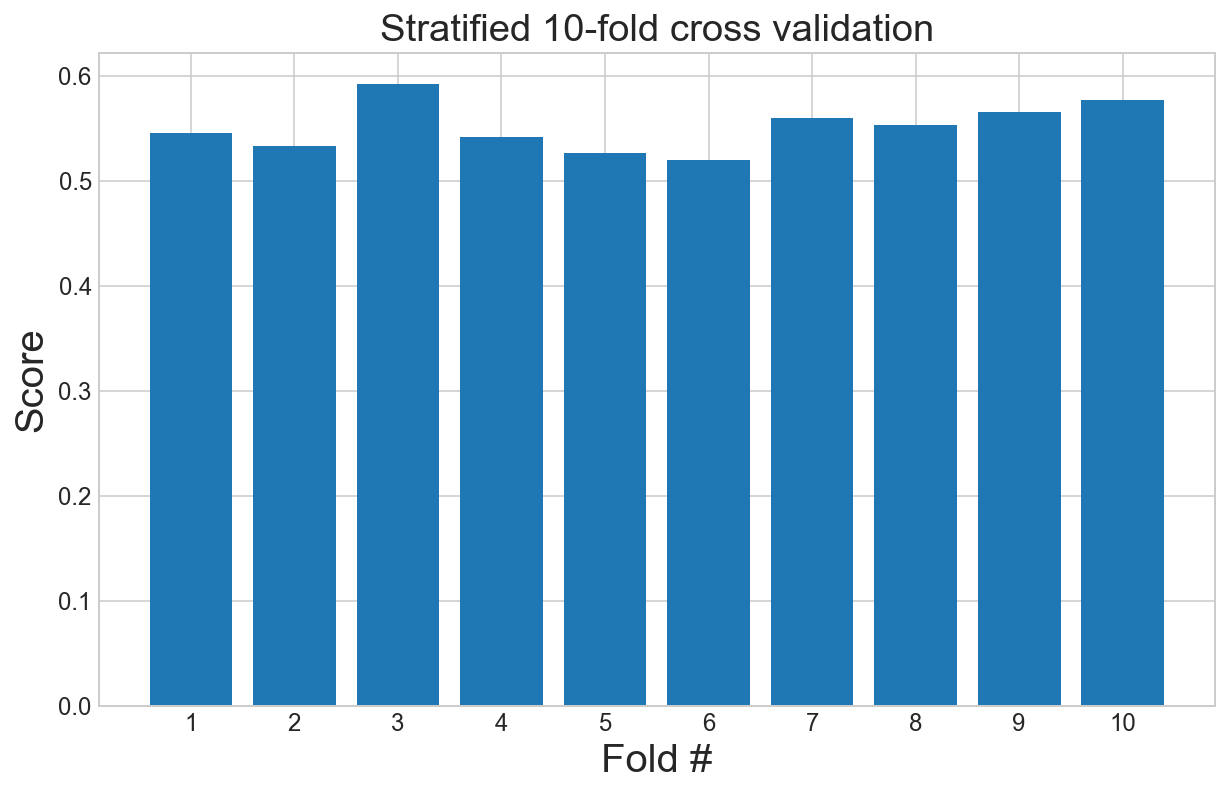

In [30]:
ax = plt.bar(range(len(scores)),scores)
plt.xticks(range(10),range(1,11))
plt.title('Stratified 10-fold cross validation')
plt.xlabel('Fold #')
plt.ylabel('Score')

print(
    '\n','='*50,'Accuracy (ROC): %0.2f (±%0.2f)' % (np.asarray(scores).mean(), np.asarray(scores).std() * 2),
    '='*50,'\n',sep='\n'
)

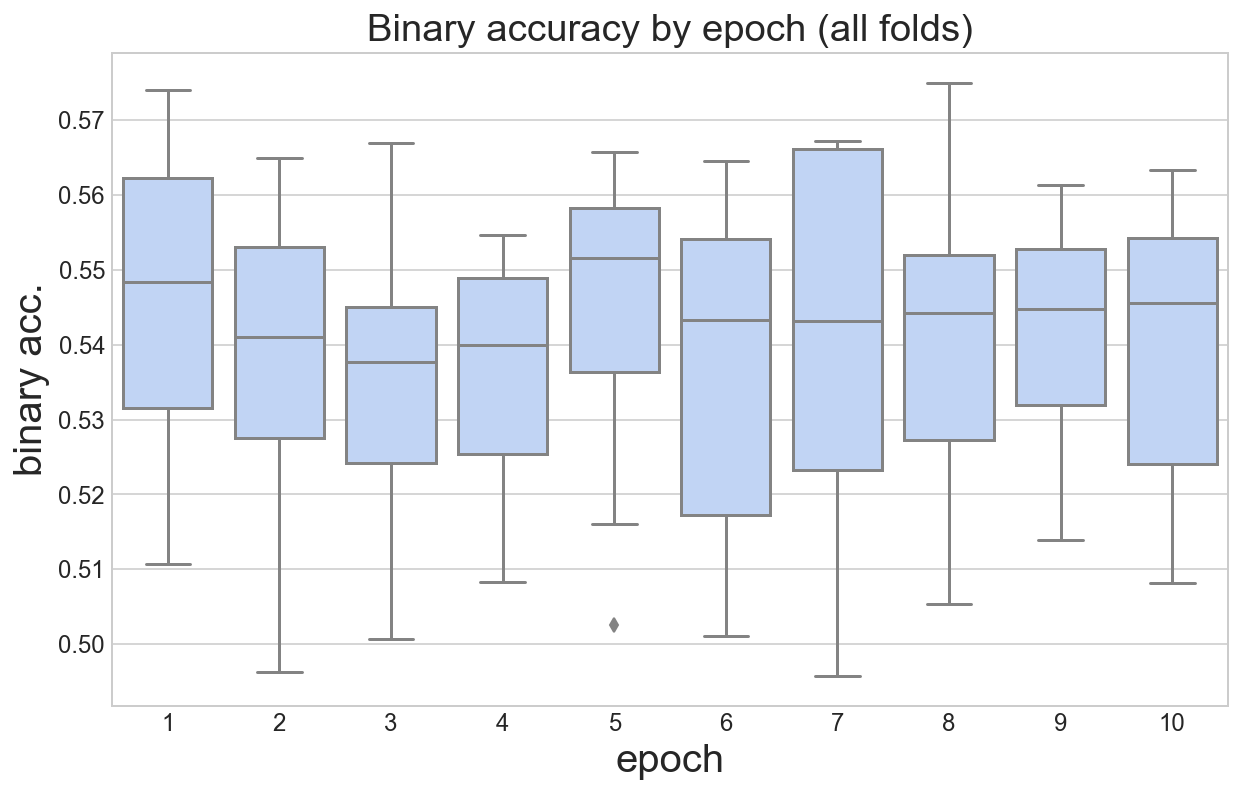

In [31]:
accs = get_logs_from_nets(nets, 'binary_accuracy')
#accs_by_epoch = [[a[i] for a in accs_by_fold] for i in range(len(accs_by_fold))]

ax = sns.boxplot(data=np.array(accs).T, color='#b8d2fc')
ax.set_xticklabels(range(1,11))
plt.xlabel('epoch')
plt.ylabel('binary acc.')
plt.title('Binary accuracy by epoch (all folds)');

# AlexNet experiment

In [90]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, BatchNormalization, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.regularizers import l2
from keras.callbacks import Callback

# We mocked the block diagram of AlexNet from the slides
# we take no credit for the general architecutre

class HighlyModularCNN:
    def __init__(
        self,
        
        ##### Shape of the network. Each entry is a single layer.
        #####  The layer are sequental starting form convolution,
        #####  batch nomalization, max pools, then dlayers. False
        #####  values mean that type of function is not added to
        #####  the layer. The default network is AlexNet
        input_shape,
        clayers = [
            ((11,11),4,96), 
            ((5,5),1,256), 
            ((3,3),1,384), 
            ((3,3),1,384),
            ((3,3),1,256), 
            False, 
            False
        ],
        max_pools = [
            ((3,3),2), 
            ((3,3),2), 
            False, 
            False, 
            ((3,3),2), 
            False, 
            False
        ],
        dlayers = [
            False, 
            False, 
            False, 
            False, 
            False, 
            4096, 
            4096
        ],
        dropout = [
            False,
            .25,
            False,
            False,
            .25,
            False,
            .5
        ],
        batch_nomalization = [
            True, 
            True, 
            False, 
            False, 
            False, 
            False, 
            True
        ],
        flatten = [
            False,
            False,
            False,
            False,
            True,
            False,
            False,
        ],
        
        kernel_initalizer = 'he_uniform',
        l2_lambda = 0.0001,
        
        activation_layers = 'relu',
        activation_final = 'softmax',
        
        output_layer_size = 2,
        
        
        ##### Model training parameters
        
        loss='mean_squared_error', 
        optimizer='rmsprop', 
        metrics=['binary_accuracy'],

        batch_size=32,
        epochs=5,
        shuffle=False,
        verbose=2
    ):
        self.input_shape = input_shape
        self.clayers = clayers
        self.batch_nomalization = batch_nomalization
        self.max_pools = max_pools
        self.dlayers = dlayers
        self.dropout = dropout
        self.flatten = flatten
        
        self.kernel_initalizer = kernel_initalizer
        self.l2_lambda = l2_lambda
        
        self.activation_layers = activation_layers
        self.activation_final = activation_final
        
        self.output_layer_size = output_layer_size
        
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.shuffle = shuffle
        self.verbose = verbose
        
        self._make_model()
                
    def _make_model(self):
        self._model = Sequential()
        
        layers = [self.clayers, self.max_pools, self.dlayers, self.dropout, self.batch_nomalization, self.flatten]
        if not all(map(lambda x: len(x)==len(layers[0]), layers)):
            raise ValueError('Every layer must be the same size')
            
        self._model.add(
            Reshape(
                (1, self.input_shape[0], self.input_shape[1]), 
                input_shape=(1, self.input_shape[0]*self.input_shape[1])
            )
        )
            
        for i in range(len(self.clayers)):
            clayer = self.clayers[i]
            batch_norm = self.batch_nomalization[i]
            max_pool = self.max_pools[i]
            dlayer = self.dlayers[i]
            drop = self.dropout[i]
            flat = self.flatten[i]
            
            if clayer:
                if not len(clayer)==3:
                    raise ValueError('Convolutional layers must have kernal size(tuple), stride(int), and # of filters(int)')
                self._model.add(
                    Conv2D(
                        kernel_size=clayer[0], 
                        strides=clayer[1], 
                        filters=clayer[2],
                        kernel_initializer=self.kernel_initalizer,
                        kernel_regularizer=l2(self.l2_lambda),
                        padding='same',
                        activation=self.activation_layers
                    )
                )
                
            if max_pool:
                if not len(max_pool)==2:
                    raise ValueError('Max Pool layer must have kernal size(tuple) and stride(int)')
                self._model.add(
                    MaxPooling2D(
                        pool_size=max_pool[0], 
                        strides=max_pool[1],
                        data_format='channels_first'
                    )
                )
                
            if dlayer:
                self._model.add(
                    Dense(dlayer, activation=self.activation_layers)
                )
                
            if drop:
                self._model.add(
                    Dropout(drop)
                )
                                        
            if batch_norm:
                self._model.add(
                    BatchNormalization()
                )
                
            if flat:
                self._model.add(
                    Flatten()
                )
        
        self._model.add(
            Dense(self.output_layer_size, activation=self.activation_final)
        )
        
        self._model.compile(
            loss=self.loss,
            optimizer=self.optimizer,
            metrics=self.metrics
        )
                
    def fit(self, X_raw, y):
        # Using keras Callbacks to hook into end of epoch
        # for per-epoch evaluation statistics collection
        # [CITE] https://github.com/fchollet/keras/issues/2548#issuecomment-215664770
        self.epoch_log_ = []
        net = self
        class AnalyticsCallback(Callback):
            def on_epoch_end(self, epoch, logs={}):
                net.epoch_log_.append(logs)
        
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        self._model.fit(
            X, y, 
           batch_size=self.batch_size,
           epochs=self.epochs,
           shuffle=self.shuffle,
           verbose=self.verbose,
           callbacks=[AnalyticsCallback()]
        )
                       
    def predict(self, X_raw):
        X = np.matrix(X_raw.tolist())
        X = np.expand_dims(X, axis=1)
        return self._model.predict(X)
    
    @staticmethod
    def one_hot_output(y_hat_raw):
        # predict() outputs floats. We want one-hot in most cases
        y_hat = np.zeros(y_hat_raw.shape, dtype=np.int)
        y_hat[np.arange(y_hat_raw.shape[0]), y_hat_raw.argmax(1)] = 1
        return y_hat

In [68]:
highlyModularCNN = dict(
        input_shape=image_size,
        clayers = [
            ((3,3),2,32),
            ((3,3),1,128), 
            ((3,3),1,128),
            False,
            False,
        ],
        max_pools = [
            ((2,2), None),
            False,
            ((2,2), None),
            False, 
            False,
        ],
        dlayers = [
            False,
            False,
            False,
            128,
            84,
        ],
        batch_nomalization = [
            True,
            True,
            False,
            False,
            False,
        ],
        dropout = [
            False,
            False,
            False,
            False,
            False,
        ],
        flatten = [
            False,
            False,
            True,
            False,
            False,
        ],
    
        activation_layers = 'relu',
    
        output_layer_size = 2,
        
        loss='mean_squared_error', 
        optimizer='Nadam', 
        metrics=['binary_accuracy'],

        batch_size=32,
        epochs=25,
        shuffle=False,
        verbose=0
)

In [69]:
%%time

data = images.image_data
target = images.is_dog

modularScores, modularNets = cross_validation(HighlyModularCNN, cv, highlyModularCNN)

Performing 10-fold Stratified cross validation with 25 epochs each (250 epochs total)
☕️ you may want to grab a coffee
Split 1 of 10 ☕️
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_47 (Reshape)         (None, 1, 32, 32)         0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 1, 16, 32)         9248      
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 1, 5, 10)          0         
_________________________________________________________________
batch_normalization_81 (Batc (None, 1, 5, 10)          40        
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 1, 5, 128)         11648     
_________________________________________________________________
batch_normalization_82 (Batc (None, 1, 5, 128)         512       
______

Split 6 of 10 ☕️☕️☕️☕️☕️☕️
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_52 (Reshape)         (None, 1, 32, 32)         0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 1, 16, 32)         9248      
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 1, 5, 10)          0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 1, 5, 10)          40        
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 1, 5, 128)         11648     
_________________________________________________________________
batch_normalization_92 (Batc (None, 1, 5, 128)         512       
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 1, 5, 128)   

CPU times: user 17min 26s, sys: 3min 26s, total: 20min 53s
Wall time: 7min 30s


[<__main__.HighlyModularCNN object at 0x1684bd208>, <__main__.HighlyModularCNN object at 0x16a274cc0>, <__main__.HighlyModularCNN object at 0x1684bd908>, <__main__.HighlyModularCNN object at 0x16c323780>, <__main__.HighlyModularCNN object at 0x16f52ff98>, <__main__.HighlyModularCNN object at 0x170e5ef98>, <__main__.HighlyModularCNN object at 0x16d16ec50>, <__main__.HighlyModularCNN object at 0x1728f1f98>, <__main__.HighlyModularCNN object at 0x1719d48d0>, <__main__.HighlyModularCNN object at 0x1714ecb70>]




Accuracy (ROC): 0.50 (±0.00)




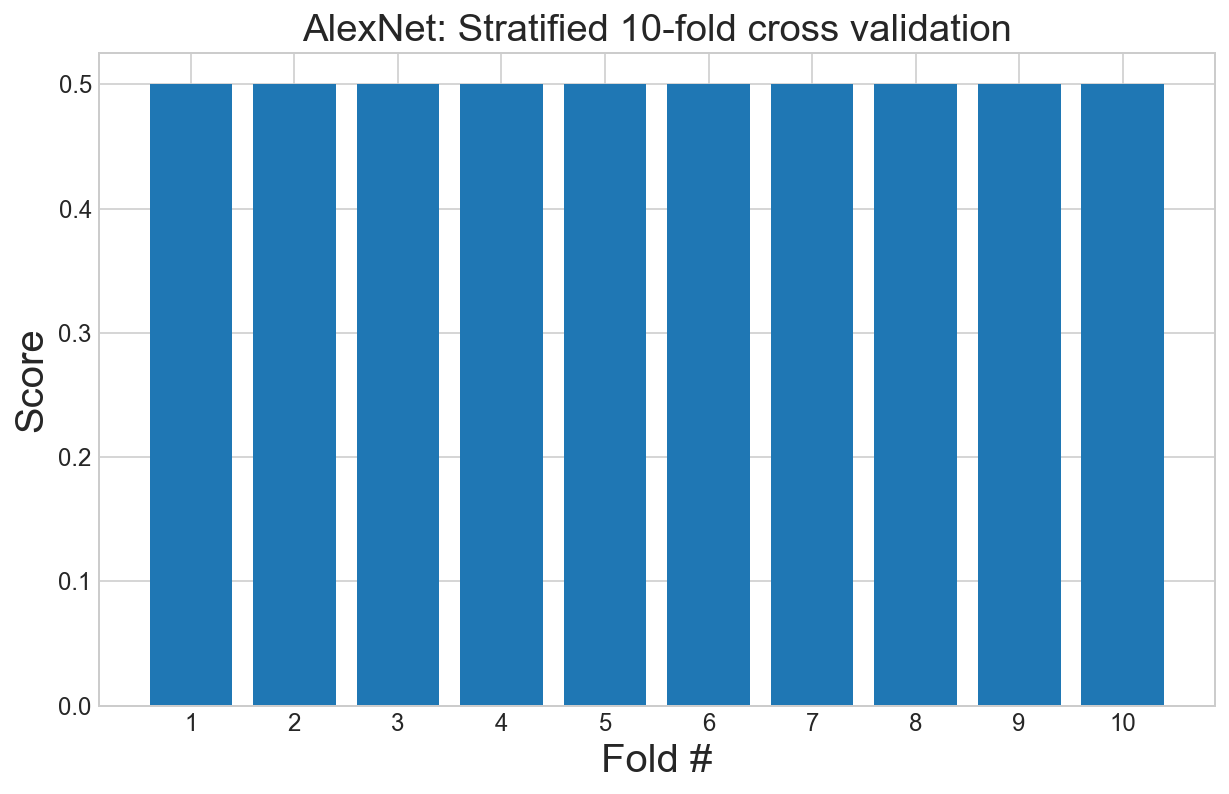

In [72]:
ax = plt.bar(range(len(modularScores)),modularScores)
plt.xticks(range(10),range(1,11))
plt.title('AlexNet: Stratified 10-fold cross validation')
plt.xlabel('Fold #')
plt.ylabel('Score')

print(
    '\n','='*50,'Accuracy (ROC): %0.2f (±%0.2f)' % (np.asarray(modularScores).mean(), np.asarray(modularScores).std() * 2),
    '='*50,'\n',sep='\n'
)

[[0.94833333333333336, 0.81092592592592594, 0.86129629629629634, 0.84796296296296292, 0.76555555555555554, 0.85888888888888892, 0.37314814814814817, 0.83185185185185184, 0.8531481481481481, 0.62555555555555553, 0.55203703703703699, 0.32092592592592595, 0.54555555555555557, 0.72777777777777775, 0.75296296296296295, 0.5, 0.76981481481481484, 0.46722222222222221, 0.50685185185185189, 0.54000000000000004, 0.66518518518518521, 0.32944444444444443, 0.72888888888888892, 0.5, 0.77259259259259261], [0.9588888888888889, 0.83851851851851855, 0.86148148148148151, 0.74203703703703705, 0.62888888888888894, 0.64851851851851849, 0.22777777777777777, 0.50907407407407412, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.95648148148148149, 0.78907407407407404, 0.64333333333333331, 0.77592592592592591, 0.69537037037037042, 0.80425925925925923, 0.5, 0.5, 0.70185185185185184, 0.77425925925925931, 0.5, 0.79203703703703698, 0.65203703703703708, 0.75185185185185188, 0.5,

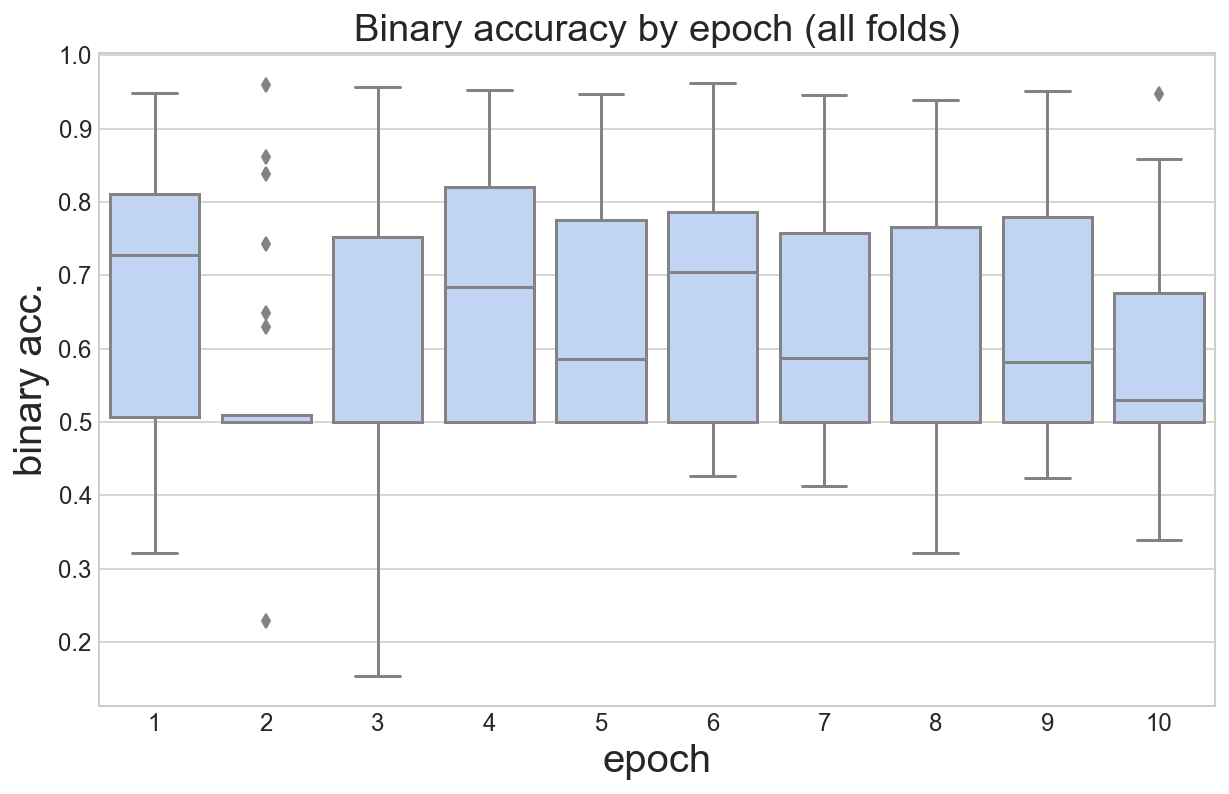

In [76]:
accs = get_logs_from_nets(modularNets, 'binary_accuracy')
print(accs)
#accs_by_epoch = [[a[i] for a in accs_by_fold] for i in range(len(accs_by_fold))]

ax = sns.boxplot(data=np.array(accs).T, color='#b8d2fc')
ax.set_xticklabels(range(1,11))
plt.xlabel('epoch')
plt.ylabel('binary acc.')
plt.title('Binary accuracy by epoch (all folds)');

# Test

In [171]:
test_param = dict(
        input_shape=image_size,
        clayers = [
            ((3,3),2,94),
            ((3,3),1,128), 
            ((3,3),1,128),
            ((3,3),1,128),
            False,
            False,
        ],
        max_pools = [
            ((2,2), None),
            False,
            False,
            ((2,2), None),
            False, 
            False,
        ],
        dlayers = [
            False,
            False,
            False,
            False,
            256,
            256,
        ],
        batch_nomalization = [
            True,
            True,
            True,
            True,
            True,
            True,
        ],
        dropout = [
            False,
            False,
            False,
            False,
            False,
            False,
        ],
        flatten = [
            False,
            False,
            False,
            True,
            False,
            False,
        ],
    
        activation_layers = 'relu',
        l2_lambda = 0.1,
    
        output_layer_size = 2,
        
        loss='mean_squared_error', 
        optimizer='Nadam', 
        metrics=['binary_accuracy'],

        batch_size=32,
        epochs=25,
        shuffle=False,
        verbose=1
)

In [172]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images.image_data, images.is_dog, test_size=0.2)

In [173]:
test_cnn = HighlyModularCNN(**test_param)
test_cnn._model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_73 (Reshape)         (None, 1, 32, 32)         0         
_________________________________________________________________
conv2d_229 (Conv2D)          (None, 1, 16, 94)         27166     
_________________________________________________________________
max_pooling2d_153 (MaxPoolin (None, 1, 8, 47)          0         
_________________________________________________________________
batch_normalization_174 (Bat (None, 1, 8, 47)          188       
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 1, 8, 128)         54272     
_________________________________________________________________
batch_normalization_175 (Bat (None, 1, 8, 128)         512       
_________________________________________________________________
conv2d_231 (Conv2D)          (None, 1, 8, 128)         147584    
__________

In [174]:
y_ohe_train = np.asarray(pd.get_dummies(y_train))
y_ohe_test  = np.asarray(pd.get_dummies(y_test))
test_cnn.fit(X_train, y_ohe_train)

Epoch 1/25
4800/4800 [==============================] - 8s - loss: 13.7613 - binary_accuracy: 0.5342     
Epoch 2/25
4800/4800 [==============================] - 3s - loss: 0.3531 - binary_accuracy: 0.5173     
Epoch 3/25
4800/4800 [==============================] - 3s - loss: 0.2965 - binary_accuracy: 0.5217     
Epoch 4/25
4800/4800 [==============================] - 3s - loss: 0.3004 - binary_accuracy: 0.5256     
Epoch 5/25
4800/4800 [==============================] - 3s - loss: 0.2984 - binary_accuracy: 0.5256     
Epoch 6/25
4800/4800 [==============================] - 3s - loss: 0.2908 - binary_accuracy: 0.5225     
Epoch 7/25
4800/4800 [==============================] - 3s - loss: 0.2945 - binary_accuracy: 0.5383     
Epoch 8/25
4800/4800 [==============================] - 3s - loss: 0.2847 - binary_accuracy: 0.5267     
Epoch 9/25
4800/4800 [==============================] - 3s - loss: 0.2822 - binary_accuracy: 0.5225     
Epoch 10/25
4800/4800 [==============================]

In [165]:
y_hat = test_cnn.predict(X_test)

In [166]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_hat.argmax(1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print(cm)
print(cm_norm)

[[387 207]
 [301 305]]
[[ 0.65151515  0.34848485]
 [ 0.49669967  0.50330033]]
